In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("MARI_KA_Monthly.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
data = pd.read_csv("MARI_KA_Monthly.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
series = data['Adj_Close']


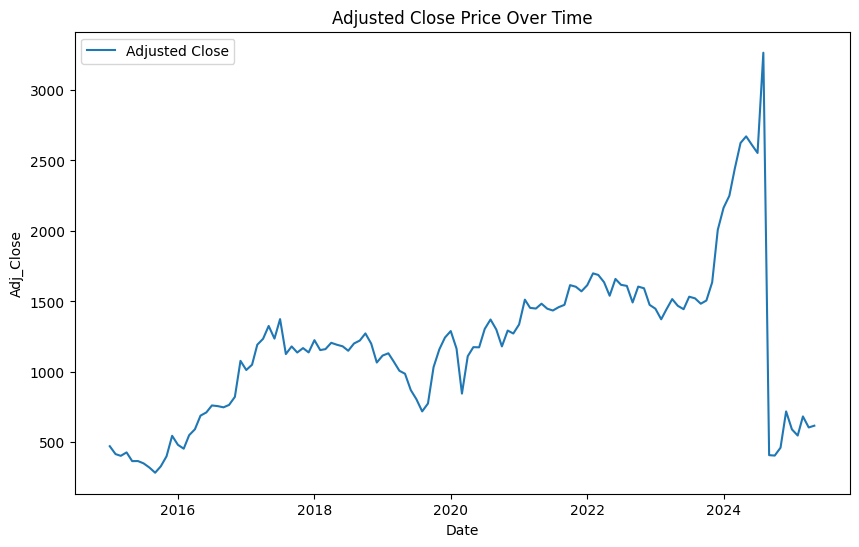

In [ ]:
# Plot the series
plt.figure(figsize=(10, 6))
plt.plot(series, label='Adjusted Close')
plt.title('Adjusted Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adj_Close')
plt.legend()
plt.show()


In [ ]:

# Calculate rolling mean and variance
window = 12  # 12-month rolling window
rolling_mean = series.rolling(window=window).mean()
rolling_var = series.rolling(window=window).var()


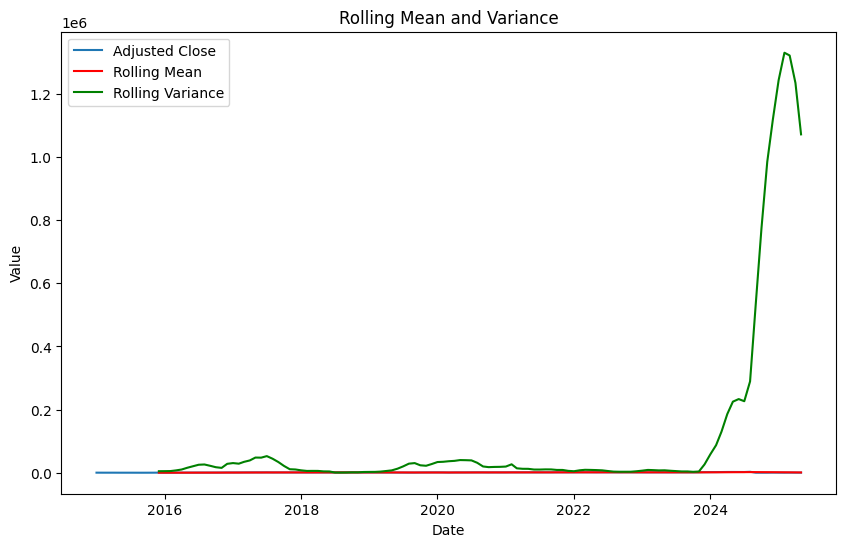

In [ ]:

# Plot rolling statistics
plt.figure(figsize=(10, 6))
plt.plot(series, label='Adjusted Close')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_var, label='Rolling Variance', color='green')
plt.title('Rolling Mean and Variance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# First-order differencing
diff_series = series.diff().dropna()

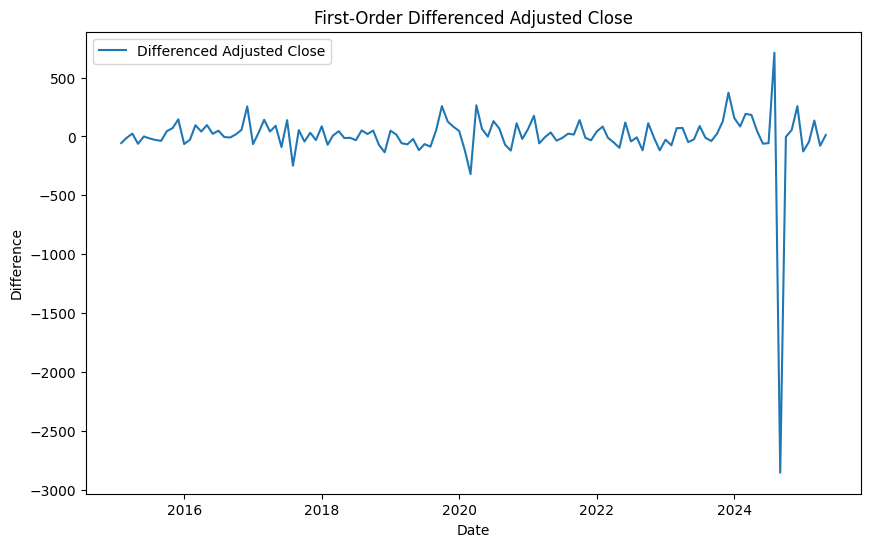

In [ ]:

# Plot differenced series
plt.figure(figsize=(10, 6))
plt.plot(diff_series, label='Differenced Adjusted Close')
plt.title('First-Order Differenced Adjusted Close')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.show()


In [ ]:

# Calculate rolling mean and variance for differenced series
rolling_mean_diff = diff_series.rolling(window=window).mean()
rolling_var_diff = diff_series.rolling(window=window).var()


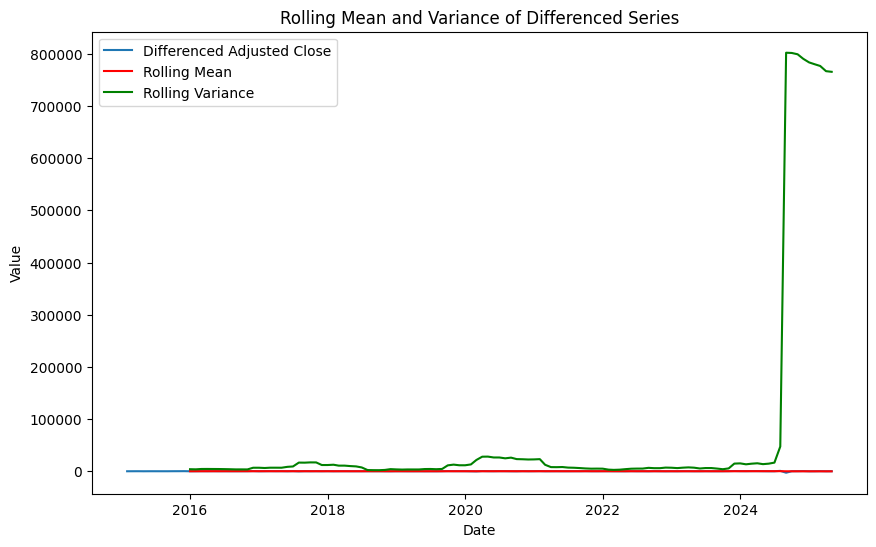

In [ ]:

# Plot rolling statistics for differenced series
plt.figure(figsize=(10, 6))
plt.plot(diff_series, label='Differenced Adjusted Close')
plt.plot(rolling_mean_diff, label='Rolling Mean', color='red')
plt.plot(rolling_var_diff, label='Rolling Variance', color='green')
plt.title('Rolling Mean and Variance of Differenced Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import norm, halfnorm

# Prepare differenced series
diff_series = series.diff().dropna().values


In [ ]:

# Define likelihood function for ARMA(1,1)
def arma11_likelihood(data, phi, theta, sigma):
    n = len(data)
    errors = np.zeros(n)
    predictions = np.zeros(n)

    # ARMA(1,1) process
    for t in range(1, n):
        predictions[t] = phi * data[t-1] + theta * errors[t-1]
        errors[t] = data[t] - predictions[t]

    # Log-likelihood (sum of log probabilities of errors)
    log_likelihood = np.sum(norm.logpdf(errors, loc=0, scale=sigma))
    return log_likelihood


In [ ]:
 #Monte Carlo simulation for Bayesian inference
n_simulations = 10000
phi_samples = norm.rvs(loc=0, scale=1, size=n_simulations)  # Prior for phi
theta_samples = norm.rvs(loc=0, scale=1, size=n_simulations)  # Prior for theta
sigma_samples = halfnorm.rvs(loc=0, scale=1, size=n_simulations)  # Prior for sigma

likelihoods = np.zeros(n_simulations)
for i in range(n_simulations):
    likelihoods[i] = arma11_likelihood(diff_series, phi_samples[i], theta_samples[i], sigma_samples[i])

In [ ]:

# Normalize likelihoods to approximate posterior weights
likelihoods = np.exp(likelihoods - np.max(likelihoods))  # Avoid numerical issues
weights = likelihoods / np.sum(likelihoods)


In [ ]:

# Estimate posterior means
phi_mean = np.sum(phi_samples * weights)
theta_mean = np.sum(theta_samples * weights)
sigma_mean = np.sum(sigma_samples * weights)

print(f"Posterior Mean phi: {phi_mean:.3f}")
print(f"Posterior Mean theta: {theta_mean:.3f}")
print(f"Posterior Mean sigma: {sigma_mean:.3f}")


Posterior Mean phi: -0.106
Posterior Mean theta: -0.174
Posterior Mean sigma: 4.048


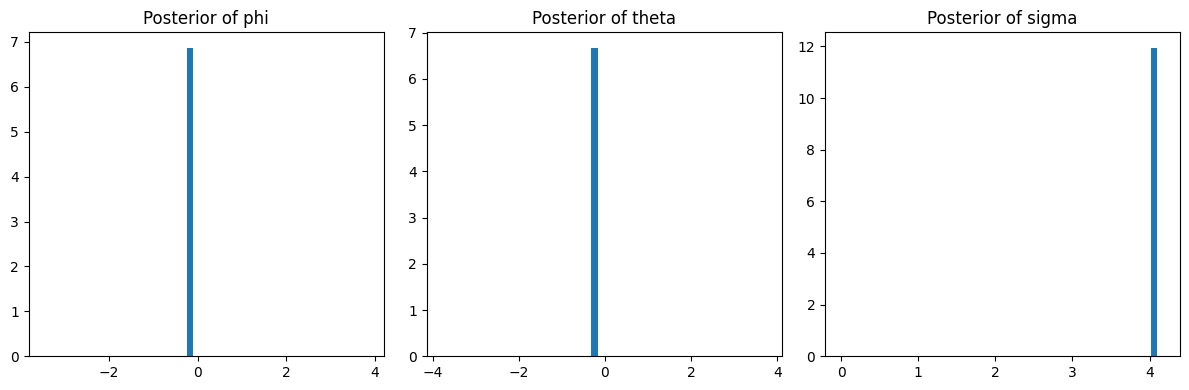

In [ ]:

# Optional: Plot posterior distributions
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(phi_samples, weights=weights, bins=50, density=True)
plt.title('Posterior of phi')
plt.subplot(1, 3, 2)
plt.hist(theta_samples, weights=weights, bins=50, density=True)
plt.title('Posterior of theta')
plt.subplot(1, 3, 3)
plt.hist(sigma_samples, weights=weights, bins=50, density=True)
plt.title('Posterior of sigma')
plt.tight_layout()
plt.show()

In [ ]:
# Forecast 12 months
n_forecast = 12
forecast_diff = np.zeros(n_forecast)
forecast = np.zeros(n_forecast)
last_value = series.iloc[-1]  # Last Adj_Close
last_diff = diff_series[-1]  # Last differenced value
last_error = 0


In [ ]:

# Use posterior means
phi = phi_mean
theta = theta_mean
sigma = sigma_mean


In [ ]:

# Forecast differenced series
for t in range(n_forecast):
    forecast_diff[t] = phi * last_diff + theta * last_error + np.random.normal(0, sigma)
    forecast[t] = last_value + forecast_diff[t]  # Integrate
    last_value = forecast[t]
    last_diff = forecast_diff[t]
    last_error = np.random.normal(0, sigma)


In [ ]:

# Create forecast index
forecast_index = pd.date_range(start=series.index[-1] + pd.offsets.MonthBegin(1), periods=n_forecast, freq='MS')


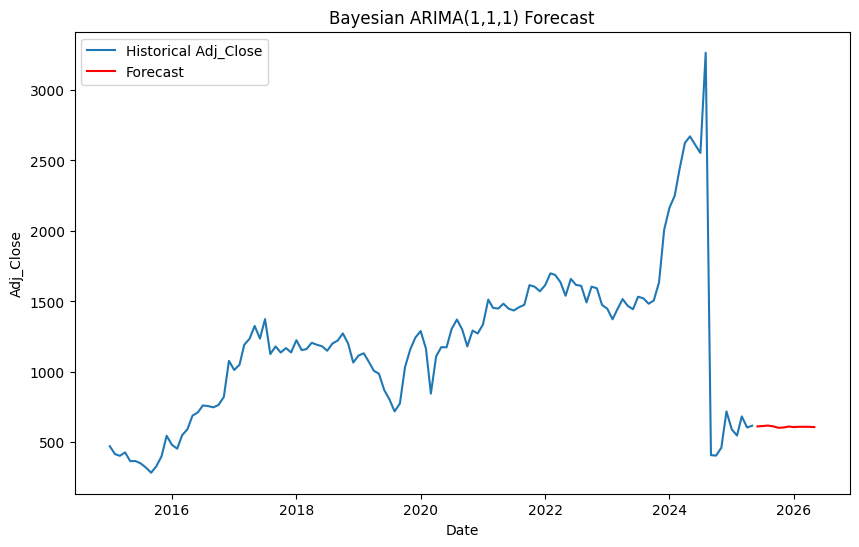

In [ ]:

# Plot historical and forecast
plt.figure(figsize=(10, 6))
plt.plot(series, label='Historical Adj_Close')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('Bayesian ARIMA(1,1,1) Forecast')
plt.xlabel('Date')
plt.ylabel('Adj_Close')
plt.legend()
plt.show()


In [ ]:

# Print forecast values
forecast_df = pd.DataFrame({'Date': forecast_index, 'Forecast_Adj_Close': forecast})
print(forecast_df)

         Date  Forecast_Adj_Close
0  2025-06-01          613.347427
1  2025-07-01          615.800309
2  2025-08-01          619.346269
3  2025-09-01          613.869898
4  2025-10-01          603.763860
5  2025-11-01          605.303601
6  2025-12-01          612.457085
7  2026-01-01          608.832719
8  2026-02-01          610.726493
9  2026-03-01          610.588986
10 2026-04-01          610.451416
11 2026-05-01          608.358556
